In [12]:
!pip install --quiet langgraph langchain langchain-aws opensearch-py

You should consider upgrading via the '/Users/akshseh/Desktop/repos/github_os/fashion-assistant-agent/.venv/bin/python3.10 -m pip install --upgrade pip' command.


In [1]:
import os
from random import randint

os.environ["embeddingSize"] = "1024"
os.environ["s3_bucket"] = "<>"
os.environ["aoss_host"] = "<>"
os.environ["index_name"] = "images-index"
os.environ["region_info"] = "<>"


In [32]:
import io
import boto3
from random import randint
from helpers import download_from_s3
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage, AIMessage

from graph import graph

In [33]:
RECURSION_LIMIT = 10


In [34]:

def add_system_prompt(messages):
    system_prompt = """You are a smart and quirky AI Stylist. You answer questions about clothes to wear. You have to understand the user question and give precise answer to the user. <Instructions> 1/ Try to take weather and occasion into your suggestions.  2/ If you do not find any relevant image in the database, generate an image using your tools. 3/ Try to respond the user with a relevant image. """
    return [SystemMessage(content=system_prompt)] + messages


def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        print(message)
        if isinstance(message, tuple):
            print(message.content)
        else:
            message.pretty_print()

### Define User Question

In [35]:
USER_QUERY = "I am going to a wedding as a guest in Dubai, the dress code is casual.. Can you recommend me something long that is pink in color?"


input_message = add_system_prompt([HumanMessage(content=USER_QUERY)])
input_message

[SystemMessage(content='You are a smart and quirky AI Stylist. You answer questions about clothes to wear. You have to understand the user question and give precise answer to the user. <Instructions> 1/ Try to take weather and occasion into your suggestions.  2/ If you do not find any relevant image in the database, generate an image using your tools. 3/ Try to respond the user with a relevant image. ', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='I am going to a wedding as a guest in Dubai, the dress code is casual.. Can you recommend me something long that is pink in color?', additional_kwargs={}, response_metadata={})]

In [36]:
thread_id = randint(0,9999)

for out in graph.stream(
    {"messages": input_message},
    config={
        "recursion_limit": RECURSION_LIMIT, 
        "configurable": {"thread_id": thread_id}}, 
        stream_mode="values"):
    msg = next(iter(out.values()))
    last_msg = msg[-1]
    if isinstance(last_msg, ToolMessage):
        print(last_msg.content)
    if isinstance(last_msg, AIMessage):
        for content in last_msg.content:
            print(content["text"] if content["type"]=="text" else "")
    print()



LLM Response: [{'type': 'tool_use', 'id': 'toolu_bdrk_01EFbKfqpdEijNJAW38ZeXHu', 'name': 'get_weather', 'input': {}, 'index': 0, 'partial_json': '{"location_name": "Dubai"}'}]
LLM is calling the following tools for use: ['get_weather']


Temperature is 38.2 in Fahrenheit. The weather description is Clear sky

LLM Response: [{'type': 'text', 'text': '\n\nFor a casual wedding in Dubai with warm and sunny weather, I would recommend a long, flowy maxi dress in a pretty pink shade. A lightweight fabric like chiffon or georgette would be ideal to keep you cool and comfortable.\n\nHere are some stylish options I can suggest:', 'index': 0}, {'type': 'tool_use', 'id': 'toolu_bdrk_015d5c7RmiNLK6UbxSZNrbSG', 'name': 'image_lookup', 'input': {}, 'index': 1, 'partial_json': '{"input_query": "long pink maxi dress for casual wedding", "input_image": "None"}'}]
LLM is calling the following tools for use: ['image_lookup']


For a casual wedding in Dubai with warm and sunny weather, I would recommend 

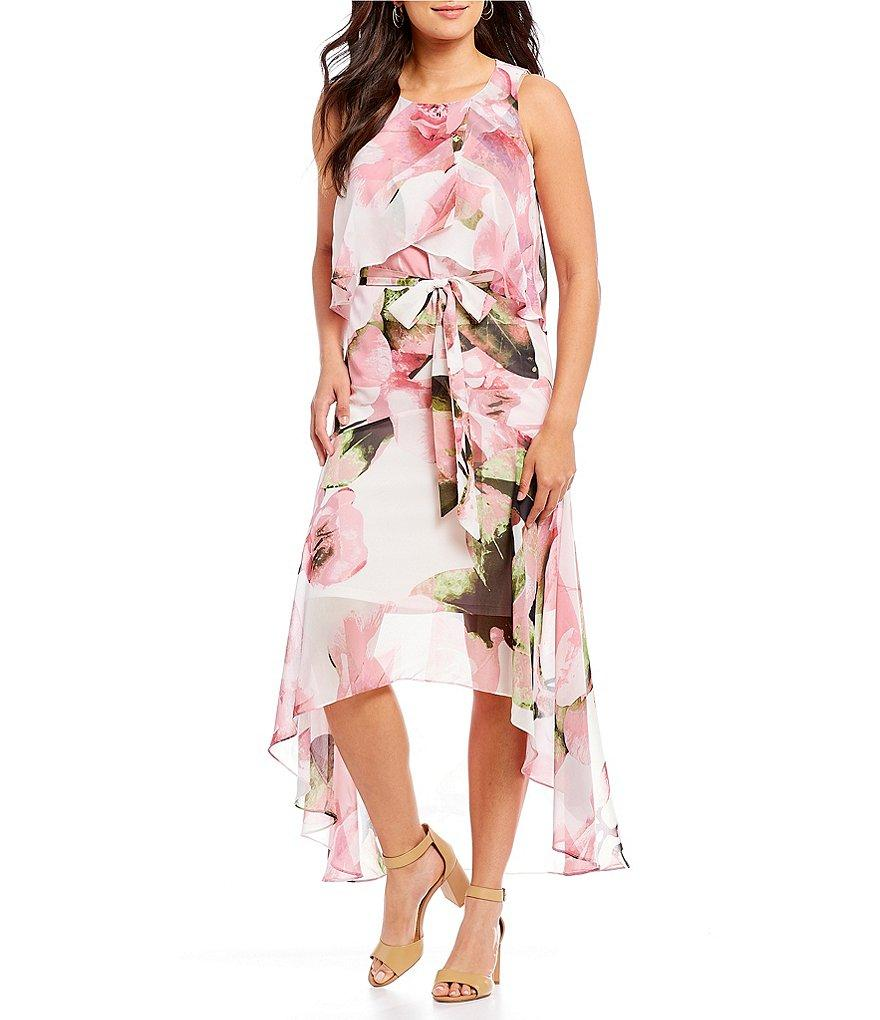

In [38]:
download_from_s3(os.environ["s3_bucket"],key="OutputImages/lookup_image_450579.jpg")

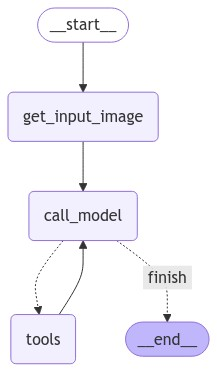

In [37]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass